In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import PIL.Image as Image

from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'

In [11]:
IMAGE_SHAPE = (224, 224)

In [6]:
classifier = Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [7]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


65536/61306 [================================] - 0s 0us/step


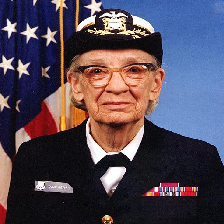

In [9]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [12]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [15]:
result = classifier.predict(grace_hopper.reshape(1,*grace_hopper.shape))
result.shape

(1, 1001)

In [16]:
predicted_class = result.argmax()
predicted_class

653

In [17]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


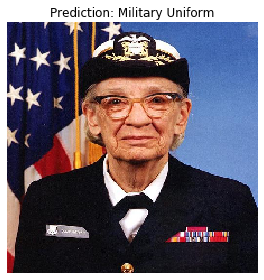

In [22]:
plt.imshow(grace_hopper)
plt.axis('off')
plt.title(f"Prediction: {imagenet_labels[predicted_class].title()}")
plt.tight_layout()

In [12]:
data_root = tf.keras.utils.get_file(
    'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [20]:
image_generator = ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(
    str(data_root), target_size=IMAGE_SHAPE, batch_size=8)

Found 3670 images belonging to 5 classes.


In [21]:
for image_batch, label_batch in image_data:
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break

Image batch shape: (8, 224, 224, 3)
Label batch shape: (8, 5)


In [7]:
result_batch = classifier.predict(image_batch)
result_batch.shape

NameError: name 'classifier' is not defined

In [8]:
predicted_class_names = imagenet_labels[result_batch.argmax(1)]
predicted_class_names

NameError: name 'imagenet_labels' is not defined

NameError: name 'predicted_class_names' is not defined

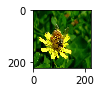

In [9]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
plt.suptitle('ImageNet predictions')
plt.tight_layout()

In [7]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [15]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE+(3,))

In [16]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(16, 1280)


In [17]:
feature_extractor_layer.trainable = False

In [18]:
image_batch.shape

(16, 224, 224, 3)

In [19]:
model = Sequential([
    feature_extractor_layer,
    Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)
predictions.shape

TensorShape([8, 5])

In [24]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

In [25]:
class CollectBatchStats(Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [26]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback = CollectBatchStats()
history = model.fit_generator(
    image_data, epochs=2,
    steps_per_epoch=steps_per_epoch,
    callbacks=[batch_stats_callback])

Epoch 1/2
459/459 [==============================] - 107s 233ms/step - loss: 0.5021 - acc: 0.8750
Epoch 2/2
459/459 [==============================] - 102s 222ms/step - loss: 0.2724 - acc: 0.8750


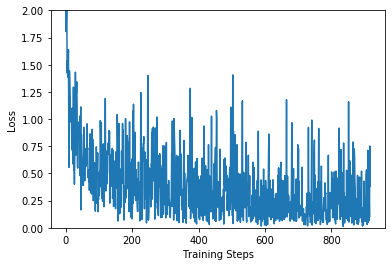

In [27]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

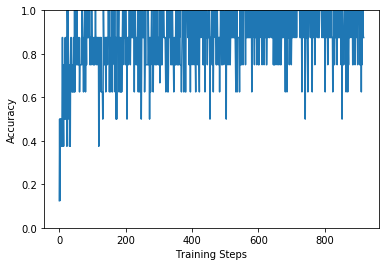

In [28]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [29]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = predicted_batch.argmax(1)
predicted_label_batch = class_names[predicted_id]

In [32]:
label_id = label_batch.argmax(1)

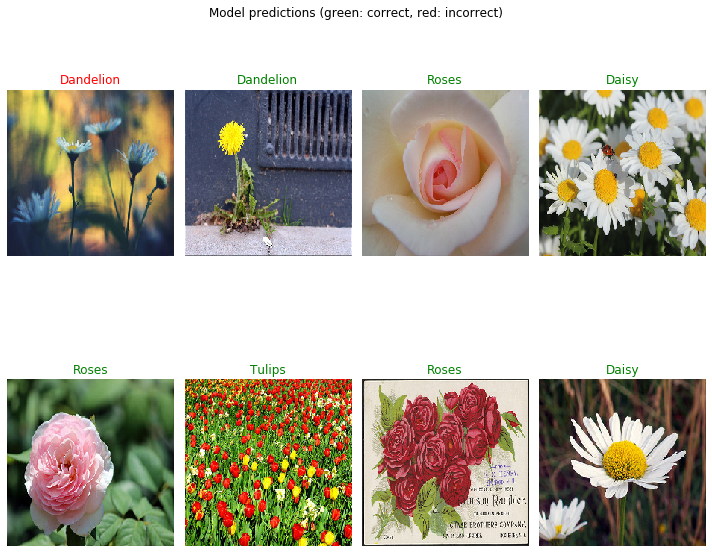

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(8):
    plt.subplot(2,4,n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')

plt.suptitle('Model predictions (green: correct, red: incorrect)')
plt.tight_layout()